In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pickle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy import signal
import nrrd
from PIL import Image

In [2]:
fname_epi = "/work/jprieto/data/remote/EGower/hinashah/Analysis_Set_11012021/trachoma_normals_healthy_sev123_epi_patches_test.csv"

df_epi = pd.read_csv(fname_epi)
df_epi.drop(df_epi[df_epi['patch_class'].isin(['Probable Epilation', 'Probable TT'])].index, inplace = True)
df_epi = df_epi.reset_index()
df_epi = df_epi.replace({'Healthy': 0, 'TT': 1, 'Epilation': 2})

with open(fname_epi.replace('.csv', '_results.pickle'), 'rb') as f:
    results_epi = pickle.load(f)

df_epi

,index,image,class,sev,epi,patch_class
0,0,hinashah/Analysis_Set_11012021/Patches/Healthy...,0,0,0,0
1,1,hinashah/Analysis_Set_11012021/Patches/Healthy...,0,0,0,0
2,2,hinashah/Analysis_Set_11012021/Patches/Healthy...,0,0,0,0
3,3,hinashah/Analysis_Set_11012021/Patches/Healthy...,0,0,0,0
4,4,hinashah/Analysis_Set_11012021/Patches/Healthy...,0,0,0,0
...,...,...,...,...,...,...
9631,9734,hinashah/Analysis_Set_11012021/Patches/Healthy...,0,0,0,0
9632,9735,hinashah/Analysis_Set_11012021/Patches/Healthy...,0,0,0,0
9633,9736,hinashah/Analysis_Set_11012021/Patches/Healthy...,0,0,0,0
9634,9737,hinashah/Analysis_Set_11012021/Patches/Healthy...,0,0,0,0


In [3]:
prediction = []
confidence = []
x_attention = []
x_v_features = []
scores = []
x_v_prediction = []
x_v_confidence = []

for prob, conf, x_a, x_v_feat, score, x_v_pred, x_v_conf in zip(results_epi[0], results_epi[1], results_epi[2], results_epi[3], results_epi[4], results_epi[5], results_epi[6]): # x, c, x_a, x_v, w_s, x_v_p, x_v_c
    prediction.append(np.argmax(prob))
    confidence.append(conf[0])
    x_attention.append(x_a)
    x_v_features.append(x_v_feat)
    scores.append(score[0])
    x_v_prediction.append(np.argmax(x_v_pred, axis=1))
    x_v_confidence.append(x_v_conf)

df_epi["pred"] = prediction
df_epi["conf"] = confidence

x_attention_np = np.reshape(np.array(x_attention), (-1, 256)).astype(float)
x_v_features_np = np.reshape(np.array(x_v_features), (len(prediction), -1, 256)).astype(float)
x_v_prediction_np = np.array(x_v_prediction)
print(x_attention_np.shape, x_v_features_np.shape, x_v_prediction_np.shape)

(9636, 256) (9636, 4, 256) (9636, 4)


In [4]:
csv_true_column = "patch_class"
csv_prediction_column = "pred"
y_true_arr = [] 
y_pred_arr = []
for idx, row in df_epi.iterrows():
  y_true_arr.append(row[csv_true_column])
  y_pred_arr.append(row[csv_prediction_column])

In [5]:
cnf_matrix = confusion_matrix(y_true_arr, y_pred_arr)
print(cnf_matrix)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print(cnf_matrix_norm)
print(classification_report(y_true_arr, y_pred_arr))

[[4437  782  142]
 [ 191 2934  213]
 [ 102  113  722]]
[[0.8276441  0.14586831 0.0264876 ]
 [0.05721989 0.87896944 0.06381067]
 [0.10885806 0.12059765 0.77054429]]
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      5361
           1       0.77      0.88      0.82      3338
           2       0.67      0.77      0.72       937

    accuracy                           0.84      9636
   macro avg       0.79      0.83      0.81      9636
weighted avg       0.85      0.84      0.84      9636



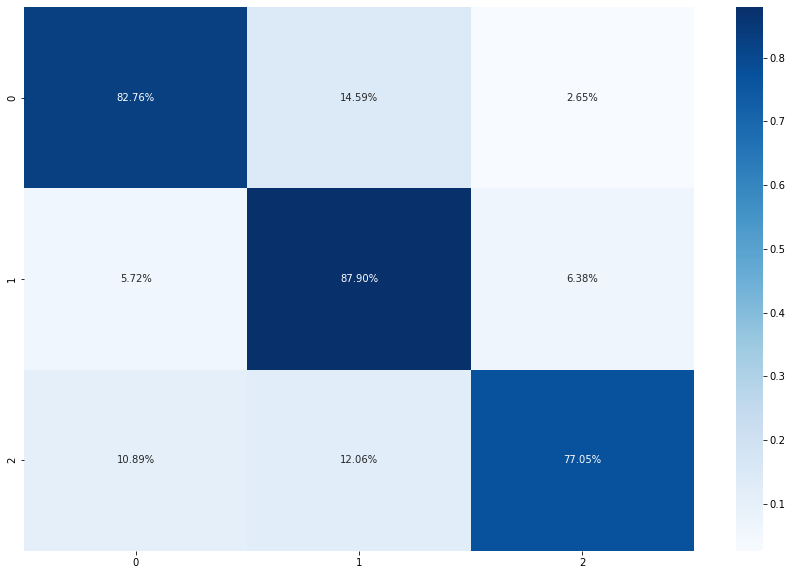

In [6]:
plt.figure(figsize=[15,10])
sns.heatmap(cnf_matrix_norm, annot=True, fmt='.2%', cmap='Blues')
plt.show()

In [7]:
# x_v_features_np = np.reshape(np.array(x_v_features), (-1, 256)).astype(float)
# print(np.shape(x_v_features_np), x_v_features_np.dtype)
# values_embedded = TSNE(n_components=2, init='pca').fit_transform(x_v_features_np)
# df_epi["tsne_0"] = values_embedded[:,0]
# df_epi["tsne_1"] = values_embedded[:,1]
# result_df["scores_max"] = [np.max(s.reshape(-1), axis=0) for s in scores]
# result_df["prediction_abs"] = np.abs(result_df["truth"] - result_df["pred"]) = np.reshape(np.array(features), (-1, 128)).astype(float)
# print(np.shape(features_np), features_np.dtype)
# X_embedded = TSNE(n_components=2, init='pca').fit_transform(features_np)
# result_df["tsne_0"] = X_embedded[:,0]
# result_df["tsne_1"] = X_embedded[:,1]
# result_df["scores_max"] = [np.max(s.reshape(-1), axis=0) for s in scores]
# result_df["prediction_abs"] = np.abs(result_df["truth"] - result_df["pred"])

In [8]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=df_epi["tsne_0"], y=df_epi["tsne_1"], mode='markers', text=df_epi["pred"], marker=dict(color=df_epi["patch_class"], size=(df_epi["pred"]+1)*5, showscale=True)))
# fig.show()

In [9]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_attention_np)
df_epi["pca_0"] = X_pca[:,0]
df_epi["pca_1"] = X_pca[:,1]

In [10]:

fig = go.FigureWidget(make_subplots(rows=2, cols=2, column_widths=[0.7, 0.3], specs=[[{'colspan': 2}, {}],[{},{}]]))

fig.add_trace(go.Scatter(x=df_epi["pca_0"], y=df_epi["pca_1"], mode='markers', showlegend=False, marker=dict(
    color=df_epi["patch_class"], size=(df_epi["pred"]+1)*5, colorscale='sunset', showscale=True, opacity=1, line=dict(color='red', width=1)
)), row=1, col=1)
fig.add_trace(go.Scatter(mode='markers', showlegend=False, marker=dict(showscale=False, cmin=0, cmax=1, size=10, colorscale='sunset', line=dict(color='red', width=1))), row=2, col=1)
fig.add_trace(go.Scatter(mode='markers', marker=dict(color='LightSkyBlue', size=10), showlegend=False), row=2, col=1)
fig.add_trace(go.Image(), row=2, col=2)

# fig.data[0].marker.showscale = True
# fig.data[0].marker.colorbar.y = 0.8
# fig.data[0].marker.colorbar.len = 0.5

# fig.data[1].marker.showscale = True
# fig.data[1].marker.colorbar.y = .2
# fig.data[1].marker.colorbar.len = 0.5

fig.update_layout(
    autosize=False,
    width=1200,
    height=800
)

current_idx = {"idx": 0, "idx_f": 0, "img_np": []}

def update_study(trace, points, selector):
    if points.trace_name == 'trace 0' and len(points.point_inds) > 0:
        print("update_study", points)
        idx = points.point_inds[0]  
        x_feat_idx = np.array(x_v_features_np[idx]).reshape(-1, 256)
        x_feat_idx_pca = pca.transform(x_feat_idx)
#         scores_idx = np.array(scores[idx]).reshape(-1)
#         weights_idx = np.array(weights[idx]).reshape(-1)
        print(x_feat_idx.shape)
        df_idx = pd.DataFrame({
            "pca_0": x_feat_idx_pca[:,0],
            "pca_1": x_feat_idx_pca[:,1],
            "prediction": np.array(x_v_prediction_np[idx]).reshape(-1)
#             ,
#             "scores": scores_idx,
#             "weights": weights_idx
            })

        with fig.batch_update():
            fig.data[1]['x'] = df_idx["pca_0"]
            fig.data[1]['y'] = df_idx["pca_1"]
            fig.data[1].marker.color = df_idx['prediction']
            fig.data[1].marker.cmin = 0
            fig.data[1].marker.cmax = 1
            print(df_idx['prediction'])

            fig.data[2]['x'] = [df_epi.loc[idx]["pca_0"]]
            fig.data[2]['y'] = [df_epi.loc[idx]["pca_1"]]

            current_idx["idx"] = idx
#             print(os.path.join("/work/jprieto/data/remote/EGower/", df_epi.loc[idx]["image"]))
#             current_idx["img_np"] = nrrd.read(os.path.join("/work/jprieto/data/remote/EGower/", df_epi.loc[idx]["image"]), index_order='C')[0]
            img_np = np.asarray(Image.open(os.path.join("/work/jprieto/data/remote/EGower/", df_epi.loc[idx]["image"])))
            img_np_shape = img_np.shape
            current_idx["img_np"] = [img_np[0:img_np_shape[0]//2, 0:img_np_shape[1]//2, :], img_np[img_np_shape[0]//2:, 0:img_np_shape[1]//2, :], img_np[0:img_np_shape[0]//2, img_np_shape[1]//2:, :], img_np[img_np_shape[0]//2:, img_np_shape[1]//2:, :]]
    
fig.data[0].on_click(update_study)

def update_img(trace, points, selector):
    if points.trace_name == 'trace 1' and len(points.point_inds) > 0:
        print('update_img', points)
        idx_f = points.point_inds[0] 
        current_idx["idx_f"] = idx_f
        with fig.batch_update():
#             fig.data[3]['z'] = current_idx["img_np"][idx_f]
            print(idx_f)
            fig.data[3]['z'] = current_idx["img_np"][idx_f]
    
fig.data[1].on_click(update_img)

fig

FigureWidget({
    'data': [{'marker': {'color': array([0, 0, 0, ..., 0, 0, 0]),
                         'col…